In [43]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
from IPython.display import display, clear_output
import helpfunction as helper

In [44]:
%matplotlib inline

In [45]:
def binom_err(bins_nom, bins_denom):
    p = bins_nom/bins_denom
    q = 1-p
    return np.sqrt(q*(1-p)/bins_denom)

In [46]:
muon_mass = 0.105658

det_x = np.array([-1.55, 254.8])
det_y = np.array([-115.53, 117.47])
det_z = np.array([0.1, 1036.9])
eps= np.array([-0.001, 0.001])


main_tree_name = 'cosmicstudies'
flash_name = b'SimpleCosmicFlashes'

outdir = './Output/SimpleCosmicFlash/'
# Input file lists
file_name_mc = './input/corsika_p_sce_30k.root'
file_name_data = './input/CosmicStudiesCRT_run3_48k_mcc9.root.root'
file_name_data = './input/extunbiased_run1_temp.root'

In [47]:
# To Do: update for logspace x axis
def histHelper(N,x_min,x_max,data,weights=0):
    edges = np.linspace(x_min,x_max,N+1)
    edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
    bins = [np.histogram(data_i,bins=edges)[0] for data_i in data]
    max_val = max([max(x) for x in bins])
    if weights==0:
        err = np.sqrt(bins)
    else:
        err = [helper.hist_bin_uncertainty(d_i, w_i, edges) for d_i, w_i in zip(data,weight)] 
    return edges, edges_mid, bins, err, max_val

In [48]:
file_mc = uproot.open(file_name_mc)[main_tree_name]
file_data = uproot.open(file_name_data)[main_tree_name]

In [49]:
file_data['Event'].numentries

22405

In [50]:
file_data.keys()

[b'pot;1',
 b'Event;1',
 b'OpBeamFlashes;1',
 b'SimpleBeamFlashes;1',
 b'OpCosmicFlashes;1',
 b'SimpleCosmicFlashes;1',
 b'PFParticles;1',
 b'Clusters;1']

In [51]:
file_mc[b'Event'].keys()

[b'event',
 b'run',
 b'subrun',
 b'pot',
 b'dataset_prescale_factor',
 b'num_simplebeamflashes',
 b'num_opbeamflashes',
 b'num_simplecosmicflashes',
 b'num_opcosmicflashes',
 b'num_pfp',
 b'num_pfp_saved',
 b'num_mcp',
 b'num_mcp_saved',
 b'num_nu',
 b'nu_vtx_x',
 b'nu_vtx_y',
 b'nu_vtx_z',
 b'nu_E',
 b'nu_time',
 b'nu_pdg_code',
 b'nu_ccnc']

In [52]:
df_flash_mc = file_mc[flash_name].pandas.df()
df_flash_data = file_data[flash_name].pandas.df()

In [53]:
df_flash_mc.head()

,event,run,subrun,num_mcp,dataset_prescale_factor,num_flashes,flash_time,flash_difftime,flash_totalPE,flash_z,flash_sz,flash_y,flash_sy,flash_width,flash_abstime,flash_num_PMT10percent
0,961,1,49,16033,1.0,20,-1181.140625,-1181.140625,7332,754.082886,112.620819,-6.651336,37.799477,0.28125,2868.828125,0
1,961,1,49,16033,1.0,20,105.953125,1287.093750,4945,942.326233,39.553207,-37.866676,34.422676,0.28125,4155.921875,0
2,961,1,49,16033,1.0,20,1695.015625,1589.062500,3118,269.854980,67.235970,-15.085605,36.120304,0.28125,5744.984375,0
3,961,1,49,16033,1.0,20,-1854.171875,-3549.187500,2381,803.274841,82.745834,6.447587,41.323135,0.28125,2195.796875,0
4,961,1,49,16033,1.0,20,1180.890625,3035.062500,2283,577.950317,63.022446,-5.989821,38.084187,0.28125,5230.859375,0


In [54]:
cols = [b'event', b'run', b'subrun', 
        b'num_simplebeamflashes', b'num_opbeamflashes', b'num_simplecosmicflashes', b'num_opcosmicflashes']
df_event_mc = file_mc[b'Event'].pandas.df(cols)
df_event_data = file_data[b'Event'].pandas.df()
print(len(df_event_mc))

29800


In [55]:
df_mcp = file_mc[b'MCParticles'].pandas.df()
nu_ori_mc = "(mc_neutrino_origin==0)"
df_mcp = df_mcp.query(nu_ori_mc)

1322472
216.0497914


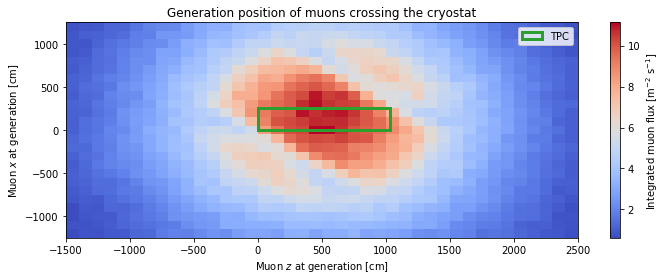

In [56]:
# Make a plot of the muon density at the generation!
df_mcp_gen = df_mcp.query('(mc_process==23) & (mc_pdg_code==13 | mc_pdg_code==-13)')
print(len(df_mcp_gen))
# Time in seconds of the sample
total_time = (max(df_mcp_gen['mc_time'])-min(df_mcp_gen['mc_time']))*1e-9*len(df_event_mc) 
print(total_time)
# Area in m*m
total_area = (40)*(25)
weights = np.full((len(df_mcp_gen)), (25*40)/total_area/total_time)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
c = ax.hist2d(df_mcp_gen["mc_startz"],df_mcp_gen["mc_startx"], range=((-1500,2500),(-1250,1250)), 
              cmap='coolwarm', bins=(40,25), weights=weights)
clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-2}$ s$^{-1}$]')
rect = patches.Rectangle((det_z[0],det_x[0]),det_z[1]-det_z[0],det_x[1]-det_x[0],
                         linewidth=3,edgecolor='C2',facecolor='none', label='TPC')
ax.add_patch(rect)
ax.legend()
ax.set_ylabel(r'Muon $x$ at generation [cm]')
ax.set_xlabel(r'Muon $z$ at generation [cm]')
ax.set_title('Generation position of muons crossing the cryostat')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/startxz_generation.pdf", bbox_inches="tight")

In [57]:
df_mcp_gen.columns
df_mcp_gen['mc_part_inside'].value_counts()

True     948192
False    374280
Name: mc_part_inside, dtype: int64

In [58]:
primary_query = '(mc_process==23)'
muon_query = '(mc_pdg_code==13 | mc_pdg_code==-13)'
cross_query = '(mc_length_tpc>5)' 
exit_tpc = '(mc_end_inside==0)'

# Fix the bug that some particles actually did not cross the tpc but seem to do
df_mc_prim_cross = df_mcp.query(primary_query +' & '+ cross_query)

cross_primary_fraction = len(df_mc_prim_cross.query(muon_query))/len(df_mc_prim_cross)
print(df_mc_prim_cross['mc_pdg_code'].value_counts()/len(df_mc_prim_cross))
print('Fraction of crossing primaries that is an (anti-)muon: {0:.2f}%'.format(cross_primary_fraction*100))
df_mc_prim_exit = df_mc_prim_cross.query(exit_tpc)
exit_primary_fraction = len(df_mc_prim_exit.query(muon_query))/len(df_mc_prim_exit)
print(df_mc_prim_exit['mc_pdg_code'].value_counts())
print('Fraction of exiting crossing primaries that is an (anti-)muon: {0:.2f}%'.format(exit_primary_fraction*100))

df_mc_muon_cross = df_mc_prim_cross.query(muon_query).copy()
df_mc_primary = df_mcp.query(primary_query).copy()
del df_mcp # free the memory of the original frame!
df_mc_muon_cross['Kinetic Energy'] = df_mc_muon_cross['mc_energy']-muon_mass

# Conclusion: the primaries inside the TPC are mainly muons, 3% are neutrons.

-13      0.538623
 13      0.426276
 2112    0.033298
 2212    0.001177
 22      0.000568
 11      0.000017
-211     0.000014
-11      0.000012
 211     0.000012
-2112    0.000002
-2212    0.000001
Name: mc_pdg_code, dtype: float64
Fraction of crossing primaries that is an (anti-)muon: 96.49%
-13      462871
 13      365154
 2112      4520
 2212        82
 22          22
-211          4
-11           1
-2112         1
Name: mc_pdg_code, dtype: int64
Fraction of exiting crossing primaries that is an (anti-)muon: 99.44%


## Plots done for MCP muons

In [59]:
# You created a frame with only primary muons! This is okay up to 1/1000
print(df_mc_muon_cross.columns)
print(df_flash_mc.columns)

Index(['event', 'run', 'subrun', 'num_mcp', 'num_mcp_saved', 'mc_energy',
       'mc_pdg_code', 'mc_status_code', 'mc_process', 'mc_end_process',
       'mc_is_matched', 'mc_start_inside', 'mc_end_inside', 'mc_part_inside',
       'crt_crossed', 'mc_neutrino_origin', 'mc_time', 'mc_startx',
       'mc_starty', 'mc_startz', 'mc_startx_tpc', 'mc_starty_tpc',
       'mc_startz_tpc', 'mc_endx', 'mc_endy', 'mc_endz', 'mc_endx_tpc',
       'mc_endy_tpc', 'mc_endz_tpc', 'mc_startmomentumx', 'mc_startmomentumy',
       'mc_startmomentumz', 'mc_length', 'mc_length_tpc', 'Kinetic Energy'],
      dtype='object')
Index(['event', 'run', 'subrun', 'num_mcp', 'dataset_prescale_factor',
       'num_flashes', 'flash_time', 'flash_difftime', 'flash_totalPE',
       'flash_z', 'flash_sz', 'flash_y', 'flash_sy', 'flash_width',
       'flash_abstime', 'flash_num_PMT10percent'],
      dtype='object')


In [60]:
# Are all muons primary? 
df_mc_muon_cross['mc_process'].value_counts()
# up to 1/1000, yes!

23    935355
Name: mc_process, dtype: int64

In [61]:
# Do all muons start outside the TPC?
df_mc_muon_cross['mc_end_inside'].value_counts()
# Yes!

False    828025
True     107330
Name: mc_end_inside, dtype: int64

In [62]:
# What fraction of muons stop inside the TPC?
stopping_fraction = df_mc_muon_cross['mc_end_inside'].value_counts().values[1]/len(df_mc_muon_cross)
print('Fraction of stopping muons: {0:.2f}%'.format(stopping_fraction*100))

Fraction of stopping muons: 11.47%


In [63]:
# Do all primary particles start at +18m above the detector?
print(df_mc_primary['mc_starty'].value_counts().values[0]/len(df_mc_primary))
# Yes!

1.0


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


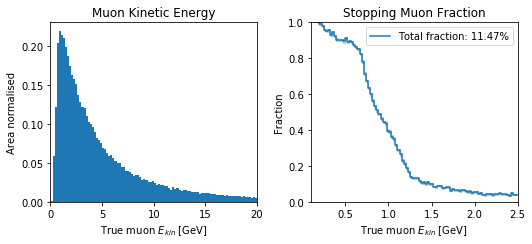

In [64]:
# make a plot of the muon kinetic energy and the fraction of stopping muons in function of that!
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
N=100
edges = np.linspace(0,20,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(df_mc_muon_cross['Kinetic Energy'], bins=edges, density=1)
ax[0].set_xlim(0,20)
ax[0].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[0].set_ylabel('Area normalised')
ax[0].set_title('Muon Kinetic Energy')

N=98
edges = np.linspace(0.1,2.5,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
denom,_ = np.histogram(df_mc_muon_cross['Kinetic Energy'], bins=edges)
nom,_ = np.histogram(df_mc_muon_cross.query('mc_end_inside')['Kinetic Energy'], bins=edges)
fraq = nom/denom

err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Total fraction: {0:.2f}%'.format(stopping_fraction*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')
ax[1].set_xlim(0.1,2.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Stopping Muon Fraction')
ax[1].legend(loc='upper right')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muon_E.pdf", bbox_inches="tight")

In [65]:
# amount of muons in the TPC:
# Time in seconds of the sample
total_time = (max(df_mc_muon_cross['mc_time'])-min(df_mc_muon_cross['mc_time']))*1e-9*len(df_event_mc) 
len(df_mc_muon_cross.query("mc_length_tpc>0"))/total_time

4329.353419144857

Muon flux: 110.24 muons/(m*s)


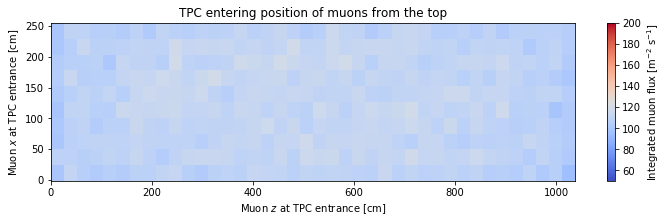

In [66]:
# Make a plot of the muon density at TPC entrance!
fig, ax = plt.subplots(1, 1, figsize=(10, 3.2))

np.full((2, 2), np.inf)

x_bin = 10
z_bin = 40
z_safe = det_z-eps
x_safe = det_x-eps

# Area in m*m
total_area = (det_x[1]-det_x[0])*(det_z[1]-det_z[0])/1e4
weights = np.full((len(df_mc_muon_cross["mc_startz_tpc"])), (x_bin*z_bin)/total_area/total_time)

c = ax.hist2d(df_mc_muon_cross["mc_startz_tpc"],df_mc_muon_cross["mc_startx_tpc"], 
              range=((z_safe[0], z_safe[1]), (x_safe[0], x_safe[1])), 
              cmap='coolwarm', bins=(z_bin,x_bin), weights=weights, vmin=50,vmax=200)

clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-2}$ s$^{-1}$]')

ax.set_ylabel(r'Muon $x$ at TPC entrance [cm]')
ax.set_xlabel(r'Muon $z$ at TPC entrance [cm]')
ax.set_title('TPC entering position of muons from the top')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/startxz_crossing.pdf", bbox_inches="tight")

loc_query = '(mc_startz_tpc>@z_safe[0]) & (mc_startz_tpc< @z_safe[1]) & \
             (mc_startx_tpc>@x_safe[0]) & (mc_startx_tpc< @x_safe[1])'
rate = len(df_mc_muon_cross.query(loc_query)["mc_startz_tpc"])/total_area/total_time
print('Muon flux: {0:.2f} muons/(m*s)'.format(rate))

In [67]:
# What is the total time of the MC sample in seconds?
total_time

216.04958280000002

(array([77., 78., 66., 74., 76., 69., 68., 75., 59., 63., 71., 72., 62.,
        76., 61., 75., 71., 69., 80., 72., 90., 63., 60., 57., 63., 76.,
        75., 58., 60.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29., 76., 77.,
        79., 77., 77., 78., 62., 68., 66., 80., 83., 62., 70., 72., 70.,
        75., 53., 53., 62., 72., 61., 67., 70., 67., 82., 74., 70., 79.,
        73., 72., 75., 63., 70., 55., 59., 68., 66.]),
 array([-0.02  , -0.0193, -0.0186, -0.0179, -0.0172, -0.0165, -0.0158,
        -0.0151, -0.0144, -0.0137, -0.013 , -0.0123, -0.0116, -0.0109,
        -0.0102, -0.0095, -0.0088, -0.0081, -0.0074, -0.0067, -0.006 ,
        -0.0053, -0.0046, -0.0039, -0.0032, -0.0025, -0.0018, -0.0011,
        -0.0004,  0.0003,  0.001 ,  0.0017,  0.0024,  0.0031,  0.0038,
         0.0045,  0.0052,  0.0059,  0.0066,  0.0073,  0.008 ,  0.0087,
        

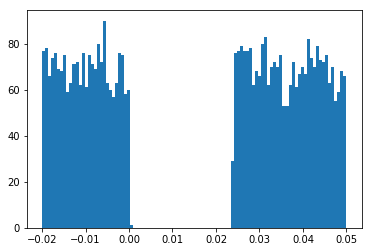

In [68]:
plt.hist(df_flash_data['flash_time']/1000, bins=100, range=(-0.02,0.05))

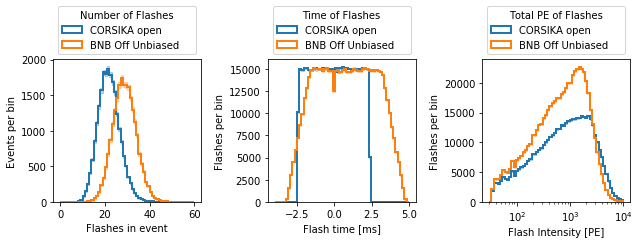

In [69]:
# number of flashes per event, PE of flashes, time of flashes
# data vs MC
# before and after timing cut

fig, ax = plt.subplots(1, 3, figsize=(9, 3.5))

mc_scale = len(df_event_data)/len(df_event_mc) 


N=60
#Num flashes
edges=np.linspace(0,60,N+1)
bins_mc,_,_ = ax[0].hist(df_event_mc['num_simplecosmicflashes'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_event_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(df_event_data['num_simplecosmicflashes'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Number of Flashes', loc='lower center', mode='expand')
ax[0].set_ylabel('Events per bin')
ax[0].set_xlabel('Flashes in event')

#Time flashes
edges=np.linspace(-4,5,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_flash_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Time of Flashes', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash time [ms]')

#PE flashes
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
bins_mc,_,_ = ax[2].hist(df_flash_mc['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_flash_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[2].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[2].hist(df_flash_data['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[2].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Total PE of Flashes', loc='lower center', mode='expand')
ax[2].set_ylabel('Flashes per bin')
ax[2].set_xlabel(r'Flash Intensity [PE]')
ax[2].set_xscale("log", nonposx='clip')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_beforetime.pdf", bbox_inches="tight")

In [70]:
df_flash_mc['flash_time'].describe()

count    636599.000000
mean        -50.082603
std        1389.103638
min       -2449.906250
25%       -1255.171875
50%         -60.578125
75%        1154.796875
max        2350.109375
Name: flash_time, dtype: float64

In [71]:
# Assume a light yield of 0.8 in data, how would this look in MC?
print(sum(df_flash_mc['flash_totalPE']>42.5)/len(df_flash_mc))
#print(np.mean(num_flash_mc))

0.9860885738117716


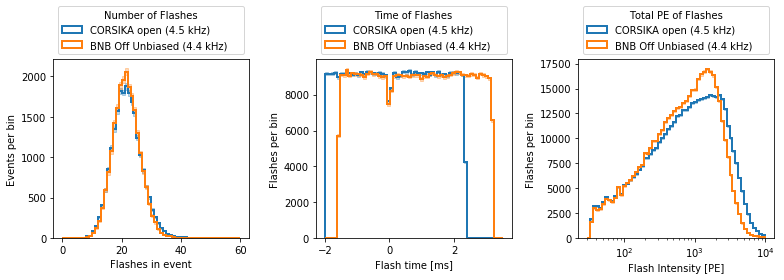

In [72]:
#mc_bounds = [25,2350,-900,-2450]
mc_bounds = [25,2350,-0,-2450]
time_query_mc= '((flash_time>@mc_bounds[0]) & (flash_time<@mc_bounds[1])) | \
                ((flash_time<@mc_bounds[2]) & (flash_time>@mc_bounds[3]))' 
time_mc = (4800-25)*1e-6

data_bounds = [25,3200,-0,-1600]
time_query_data= '((flash_time>@data_bounds[0]) & (flash_time<@data_bounds[1])) | \
                  ((flash_time<@data_bounds[2]) & (flash_time>@data_bounds[3]))'
time_data = (4800-25)*1e-6

df_flash_mc_time = df_flash_mc.query(time_query_mc)
df_flash_data_time = df_flash_data.query(time_query_data)

mc_rate = len(df_flash_mc_time)/(len(df_event_mc)*time_mc)/1000
data_rate = len(df_flash_data_time)/(len(df_event_data)*time_data)/1000


num_flash_mc = df_flash_mc_time.groupby(['run', 'subrun', 'event', 'num_mcp']).size()
num_flash_data = df_flash_data_time.groupby(['run', 'subrun', 'event']).size()

fig, ax = plt.subplots(1, 3, figsize=(11, 4))
mc_scale = len(df_event_data)/len(df_event_mc) 


N=60
#Num flashes
edges=np.linspace(0,60,N+1)
bins_mc,_,_ = ax[0].hist(num_flash_mc, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', 
                         weights=[mc_scale]*len(num_flash_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(num_flash_data, bins=edges, histtype='step', lw=2,
                           label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Number of Flashes', loc='lower center', mode='expand')
ax[0].set_ylabel('Events per bin')
ax[0].set_xlabel('Flashes in event')

#Time flashes
N=60
edges=np.linspace(-2,3.5,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc_time['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data_time['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Time of Flashes', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash time [ms]')

#PE flashes
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
bins_mc,_,_ = ax[2].hist(df_flash_mc_time['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[2].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[2].hist(df_flash_data_time['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')

temp = np.append(bins_data, bins_data[-1])
ax[2].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Total PE of Flashes', loc='lower center', mode='expand')
ax[2].set_ylabel('Flashes per bin')
ax[2].set_xlabel(r'Flash Intensity [PE]')
ax[2].set_xscale("log", nonposx='clip')

fig.tight_layout()
fig.savefig("./Output/SimpleCosmicFlash/flash_aftertime.pdf", bbox_inches="tight")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


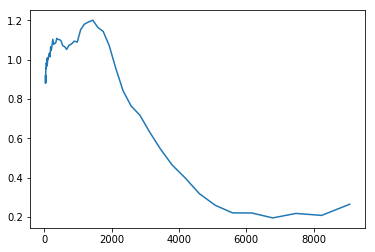

In [73]:
plt.plot(edges[:-1], bins_data/bins_mc)
plt.show()

In [74]:
# Event run and subrun are not unique in MC:
print(len(df_flash_mc_time.groupby(['run', 'subrun', 'event', 'num_mcp'])))
print(len(df_event_mc))

print(len(df_event_mc)*time_mc)

print(len(df_event_data)*time_data)


29800
29800
142.295
106.983875


In [80]:
print(mc_rate, 1/np.sqrt(mc_rate*1000*142.295)*mc_rate)

4.472110755824168 0.005606107939263312


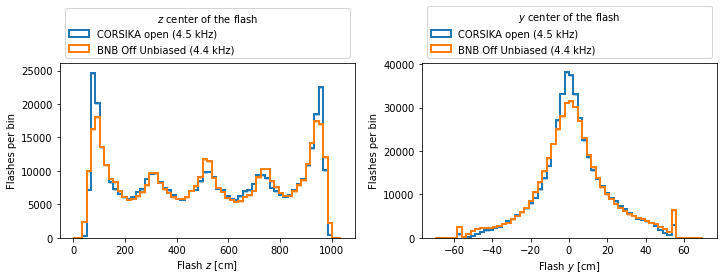

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(10.2, 4))
mc_scale = len(df_event_data)/len(df_event_mc) 


N=60

#Time flashes
edges=np.linspace(0,1036.8,N+1)
bins_mc,_,_ = ax[0].hist(df_flash_mc_time['flash_z'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(df_flash_data_time['flash_z'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=r'$z$ center of the flash', loc='lower center', mode='expand')
ax[0].set_ylabel('Flashes per bin')
ax[0].set_xlabel(r'Flash $z$ [cm]')

#PE flashes
edges=np.linspace(-70,70,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc_time['flash_y'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data_time['flash_y'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=r'$y$ center of the flash', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash $y$ [cm]')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_aftertime_yz.pdf", bbox_inches="tight")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


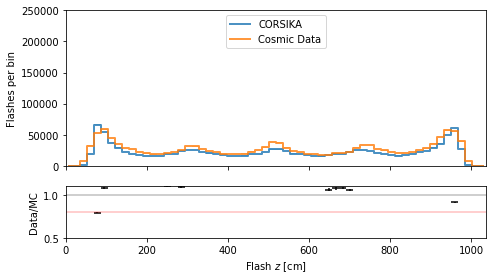

In [77]:
clean = False

t_data_r1 = 773.26
r_data_r1 = 4.373

scale = [mc_scale*time_data/time_mc, 1]
scale = [773.26/382, 773.26/234.170775*4.373/data_rate]

x_min = 0
x_max = 1036.8
N = 60

fig, ax = plt.subplots(nrows = 2, sharex=True, figsize=(7,4), gridspec_kw = {'height_ratios':[3, 1]})
data = [df_flash_mc_time['flash_z'], df_flash_data_time['flash_z']]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
labs=['CORSIKA', 'Cosmic Data']
for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
    ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')

#ax[0].set_ylim(0,max_y*1.4*mc_scale)
ax[0].set_ylim(0,250000)
ax[0].set_ylabel("Flashes per bin")
ax[0].set_xlim(x_min,x_max)
ax[0].legend(loc='upper center')

ratio = (bins[1]*scale[1])/(bins[0]*scale[0])
ratio_err = 1/np.sqrt(bins[1]) #only do the error on data, mc error is super tiny
ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color='k')
ax[1].axhline(y=1,color="k",alpha=0.25)
ax[1].axhline(y=0.8,color="r",alpha=0.25)
ax[1].set_xlabel(r'Flash $z$ [cm]')
ax[1].set_ylabel("Data/MC")
ax[1].set_ylim(0.5,1.1)
fig.tight_layout()
fig.savefig(outdir+"_flash_center_run_31_datamc.pdf")

In [78]:
print(edges[6:-6])
print(bins[0][6:-6]*scale[0])
print((sum(bins[1][6:-6])*scale[1])/(sum(bins[0][6:-6])*scale[0]))

[103.68 120.96 138.24 155.52 172.8  190.08 207.36 224.64 241.92 259.2
 276.48 293.76 311.04 328.32 345.6  362.88 380.16 397.44 414.72 432.
 449.28 466.56 483.84 501.12 518.4  535.68 552.96 570.24 587.52 604.8
 622.08 639.36 656.64 673.92 691.2  708.48 725.76 743.04 760.32 777.6
 794.88 812.16 829.44 846.72 864.   881.28 898.56 915.84 933.12]
[36389.77753927 29371.73455497 22394.17638743 19539.99680628
 17618.99225131 16228.33879581 15600.82413613 16467.19921466
 18477.27036649 19631.08764398 23709.93293194 25697.73743455
 25894.08879581 22582.43078534 19991.40251309 19042.03356021
 17068.39874346 15627.13926702 15313.38193717 16584.60518325
 19015.71842932 19426.63931937 22667.44890052 26444.68230366
 26539.82162304 24398.17481675 19805.17235602 19240.4091623
 16876.09586387 15517.83026178 15210.14565445 16704.03539267
 18641.23387435 19201.94858639 21778.80717277 25191.67722513
 25185.60450262 23938.6721466  20086.54183246 18760.66408377
 17284.99251309 16608.8960733  17129.12596859 1

In [79]:
# Correct for 8us dead time after each flash!
from scipy.optimize import fsolve
func = lambda x : R - x*np.exp(-8e-6*x)
a_initial_guess = 5000

R= mc_rate*1000
print(fsolve(func, a_initial_guess)[0])
R= data_rate*1000
print(fsolve(func, a_initial_guess)[0])

print(1-4641/4592)

4641.282659770649
4592.753690196313
-0.010670731707317138


## Below this: muon flash matching! Only MC

In [62]:
# A flash is matched to a particle if it is in this interval
fl_diff_start = 0.05 
fl_diff_end = 0.35
max_events = 10000

df_mc_primary = df_mc_primary[df_mc_primary['mc_time'].between(-2450000,2350000)].reset_index(drop=True)
df_mc_muon_cross = df_mc_muon_cross[df_mc_muon_cross['mc_time'].between(-2450000,2350000)].reset_index(drop=True)
df_mc_muon_cross['mc_avgx_tpc'] = (df_mc_muon_cross['mc_startx_tpc']+df_mc_muon_cross['mc_endx_tpc'])/2

# choose if we want to match with crossing muons or with all primaries
mcp_df = df_mc_primary #df_mc_muon_cross #

# Make a run, subrun, event frame (df_events has a bug currently)
df_event=df_flash_mc[['event','run','subrun','num_mcp']].drop_duplicates().reset_index(drop=True)

In [63]:
simple_diff_times=[]

n_muons=0
n_simple=0

index_mcp_good=[]
index_mcp_all=[]
index_simple_good=[]
index_simple_all=[]

time_dif_all = []
time_dif_matched = []


for index, row in df_event.head(max_events).iterrows():
    event,run,subrun, num_mcp = row[['event','run','subrun', 'num_mcp']]
    selection_string = 'event==@event & run==@run & subrun==@subrun & num_mcp==@num_mcp'
    
    t_prevmu = 99999
    
    df_temp = mcp_df.query(selection_string)
    mc_indexes = df_temp.index.values
    mc_times = df_temp['mc_time']/1000
    
    df_temp = df_flash_mc.query(selection_string)
    simple_indexes = df_temp.index.values 
    simple_times = df_temp['flash_time']
    
    clear_output(wait=True)
    print('index',index,'mc_times', len(mc_times), 'simple_times',len(simple_times))

    n_muons+=len(mc_times)
    n_simple+=len(simple_times)
    
    # Store the all indices:
    index_simple_all.extend(simple_indexes)
    index_mcp_all.extend(mc_indexes)
    
    # Do the matching based on time only
    for mc_index, mc_time in zip(mc_indexes, mc_times):
        temp_bool = False
        if not temp_bool: 
            temp = simple_times-mc_time
            if(len(temp[temp>0])>0):  # if (temp>0).any()
                temp_diff = min(temp[temp>0])
                simple_diff_times.append(temp_diff)
                if fl_diff_start < temp_diff < fl_diff_end:             
                    index = simple_indexes[np.where(temp == temp_diff)]    
                    index_simple_good.extend(index)
                    index_mcp_good.append(mc_index)
                    time_dif_matched.append(mc_time-t_prevmu)
                    temp_bool=True 
        
        # Add time diff
        time_dif_all.append(mc_time-t_prevmu)
        t_prevmu = mc_time
            
index_mcp_bad = np.setdiff1d(index_mcp_all,index_mcp_good)
index_simple_bad = np.setdiff1d(index_simple_all,index_simple_good)

print('Number of muons we tried to match:',n_muons,', matched: '
      ,len(index_mcp_good), ', failed: ', len(index_mcp_bad),', Efficiency: ',
      (round(len(index_mcp_good)/n_muons*1000)/10),'%.')
print('Number of simpleflashes we tried to match:',n_simple,', matched: '
      ,len(index_simple_good), ', failed: ', len(index_simple_bad),', Efficiency: ',
      (round(len(index_simple_good)/n_simple*1000))/10,'%.')


index 9999 mc_times 29 simple_times 22
Number of muons we tried to match: 321030 , matched:  208499 , failed:  112531 , Efficiency:  64.9 %.
Number of simpleflashes we tried to match: 213768 , matched:  208499 , failed:  5829 , Efficiency:  97.5 %.


In [64]:
if 0:
    index_mcp_good_mu = index_mcp_good
    index_mcp_all_mu = index_mcp_all
    index_mcp_bad_mu = index_mcp_bad
    
    index_simple_good_mu = index_simple_good
    index_simple_all_mu = index_simple_all
    index_simple_bad_mu = index_simple_bad

    time_dif_all_mu = time_dif_all
    time_dif_matched_mu = time_dif_matched
    
    simple_diff_times_mu = simple_diff_times
    
    #Number of muons we tried to match: 261179 , matched:  212286 , failed:  48893 , Efficiency:  81.3 %.
    #Number of simpleflashes we tried to match: 259482 , matched:  212286 , failed:  47436 , Efficiency:  81.8 %.

In [65]:
# Only if we are matchign with all primaries
# Which primary particles do create flashes 
print(mcp_df.iloc[index_mcp_good]['mc_pdg_code'].value_counts()/len(index_mcp_good)*0.977)
# Which flashes are casued by tpc crossing particles
print(mcp_df.iloc[index_mcp_good]['mc_part_inside'].value_counts()/len(index_mcp_good)*0.977)

-13      0.525722
 13      0.418238
 2112    0.024601
 22      0.003828
 2212    0.002287
-11      0.001153
 11      0.001129
-211     0.000028
 211     0.000009
-2112    0.000005
Name: mc_pdg_code, dtype: float64
True     0.833195
False    0.143805
Name: mc_part_inside, dtype: float64


In [66]:
# end process of neutrons creatign flashes is inelestic scattering
mcp_df.iloc[index_mcp_good].query('mc_pdg_code==2112')['mc_end_process'].value_counts()

18    5250
Name: mc_end_process, dtype: int64

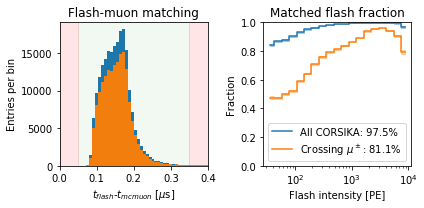

In [75]:
# make a plot of flash muon time difference and the flashmatch PE efficiency:

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
N=50
edges = np.linspace(0,0.4,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(np.array(simple_diff_times), bins=edges)
bins_mu,_,_ = ax[0].hist(np.array(simple_diff_times_mu), bins=edges)

ax[0].set_xlabel(r'$t_{flash}$-$t_{mcmuon}$ [$\mu$s]')
ax[0].set_ylabel('Entries per bin')
ax[0].set_title('Flash-muon matching')
ax[0].axvspan(0,fl_diff_start, alpha=0.1, color="red")
ax[0].axvspan(fl_diff_start,fl_diff_end, alpha=0.05, color="green")
ax[0].axvspan(fl_diff_end,0.4, alpha=0.1, color="red")
ax[0].set_xlim(0,0.4)
#ax[0].set_ylim(0,1000)

N=19
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

# For all mcp
denom,_ = np.histogram(df_flash_mc.iloc[index_simple_all]['flash_totalPE'], bins=edges)
nom,_ = np.histogram(df_flash_mc.iloc[index_simple_good]['flash_totalPE'], bins=edges)
fraq = nom/denom
ratio = len(df_flash_mc.iloc[index_simple_good])/len(df_flash_mc.iloc[index_simple_all])
err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'All CORSIKA: {0:.1f}%'.format(ratio*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')

# For crossing muons
denom,_ = np.histogram(df_flash_mc.iloc[index_simple_all_mu]['flash_totalPE'], bins=edges)
nom,_ = np.histogram(df_flash_mc.iloc[index_simple_good_mu]['flash_totalPE'], bins=edges)
fraq = nom/denom
ratio = len(df_flash_mc.iloc[index_simple_good_mu])/len(df_flash_mc.iloc[index_simple_all_mu])
err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Crossing $\mu^\pm$: {0:.1f}%'.format(ratio*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')

ax[1].set_ylim(0.,1.)
ax[1].set_xlabel(r'Flash intensity [PE]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Matched flash fraction')
ax[1].set_xscale("log", nonposx='clip')
ax[1].legend()

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_muon_matching.pdf", bbox_inches="tight")

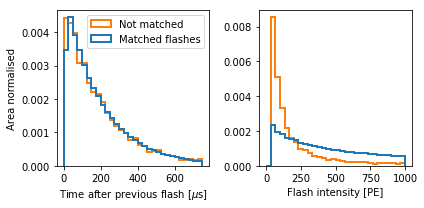

In [68]:
# The flashes arer sorted using PE, so we need to recalculate the time diff.
df_flash_mc_sorted = df_flash_mc.sort_values(by=['event','run','subrun','flash_time'])
df_flash_mc_sorted['flash_difftime2'] = df_flash_mc_sorted['flash_time']-np.roll(df_flash_mc_sorted['flash_time'],1) 

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
labs = ['Matched flashes','Not matched']

data = [df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_good)]['flash_difftime2'],
        df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_bad)]['flash_difftime2']]
ax[0].hist(data, histtype='step', density=1,bins=30,range=(0,750),lw=2, label=labs)
data = [df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_good)]['flash_totalPE'],
        df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_bad)]['flash_totalPE']]
ax[1].hist(data, histtype='step', density=1,bins=30,range=(0,1000),lw=2)
ax[0].legend()
ax[0].set_xlabel("Time after previous flash [$\mu$s]")
ax[1].set_xlabel("Flash intensity [PE]")
ax[0].set_ylabel("Area normalised")

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_latelightcheck.pdf", bbox_inches="tight")

In [69]:
df_flash_mc.columns

Index(['event', 'run', 'subrun', 'num_mcp', 'dataset_prescale_factor',
       'num_flashes', 'flash_time', 'flash_difftime', 'flash_totalPE',
       'flash_z', 'flash_sz', 'flash_y', 'flash_sy', 'flash_width',
       'flash_abstime', 'flash_num_PMT10percent'],
      dtype='object')

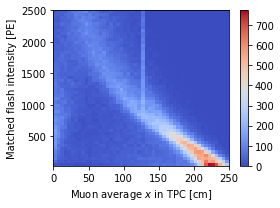

In [70]:
#print(index_simple_good)
data_fl = df_flash_mc.iloc[index_simple_good_mu]['flash_totalPE']
data_mc_avgx = df_mc_muon_cross.iloc[index_mcp_good_mu]['mc_avgx_tpc']

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

c = ax.hist2d(data_mc_avgx, data_fl, range=((0,250),(30,2500)), cmap='coolwarm', bins=(50,50))
plt.colorbar(c[3], ax=ax)
ax.set_xlabel('Muon average $x$ in TPC [cm]')
ax.set_ylabel('Matched flash intensity [PE]')
fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mux_flashPE.pdf", bbox_inches="tight")

In [71]:
df_mc_muon_cross['mc_avgy_tpc'] = (df_mc_muon_cross['mc_starty_tpc']+df_mc_muon_cross['mc_endy_tpc'])/2
df_mc_muon_cross['mc_avgz_tpc'] = (df_mc_muon_cross['mc_startz_tpc']+df_mc_muon_cross['mc_endz_tpc'])/2

df_mc_muon_cross['mc_mom_x_yz'] = df_mc_muon_cross['mc_startmomentumx'] / (df_mc_muon_cross['mc_startmomentumy']**2+df_mc_muon_cross['mc_startmomentumz']**2)**0.5
df_mc_muon_cross['mc_mom_z_xy'] = df_mc_muon_cross['mc_startmomentumz'] / (df_mc_muon_cross['mc_startmomentumx']**2+df_mc_muon_cross['mc_startmomentumy']**2)**0.5
df_mc_muon_cross['mc_mom_y_zx'] = df_mc_muon_cross['mc_startmomentumy'] / (df_mc_muon_cross['mc_startmomentumz']**2+df_mc_muon_cross['mc_startmomentumx']**2)**0.5

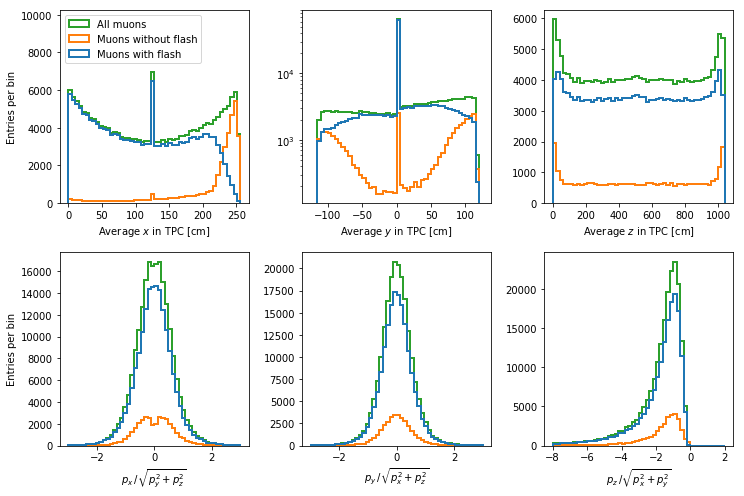

In [72]:
fig, ax = plt.subplots(2, 3, figsize=(10.5, 7))

field = 'mc_avgx_tpc'
data1 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]

field = 'mc_avgy_tpc'
data2 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]
field = 'mc_avgz_tpc'
data3 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]

field = 'mc_mom_x_yz'
data4 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]
field = 'mc_mom_z_xy'
data5 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]
field = 'mc_mom_y_zx'
data6 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]

labs = ['Muons with flash', 'Muons without flash', 'All muons']

ax[0][0].hist(data1,label=labs,histtype='step',lw=2,bins=50,range=(0,256))
ax[0][0].set_ylim(0,1.4*ax[0][0].get_ylim()[1])
ax[0][1].hist(data2,label=labs,histtype='step',lw=2,bins=50,range=(-125,125))
ax[0][2].hist(data3,label=labs,histtype='step',lw=2,bins=50,range=(0,1040))

ax[1][0].hist(data4,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-3,3))
ax[1][1].hist(data5,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-3,3))
ax[1][2].hist(data6,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-8,2))

ax[0][0].set_xlabel(r'Average $x$ in TPC [cm]')
ax[0][1].set_xlabel(r'Average $y$ in TPC [cm]')
ax[0][2].set_xlabel(r'Average $z$ in TPC [cm]')
ax[0][1].set_yscale('log')

ax[1][0].set_xlabel(r'$p_x \:/ \sqrt{p_y^2+p_z^2}$')
ax[1][1].set_xlabel(r'$p_y \:/ \sqrt{p_x^2+p_z^2}$')
ax[1][2].set_xlabel(r'$p_z \:/ \sqrt{p_x^2+p_y^2}$')

ax[0][0].set_ylabel('Entries per bin')
ax[1][0].set_ylabel('Entries per bin')
ax[0][0].legend(loc='upper left')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muons2.pdf", bbox_inches="tight")

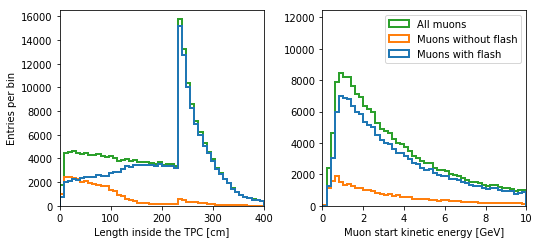

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(7.6, 3.5))

field = 'mc_length_tpc'
data1 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]
field = 'Kinetic Energy'
data2 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]

ax[0].hist(data1,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,400))
ax[1].hist(data2,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,10))
ax[1].set_ylim(0,1.4*ax[1].get_ylim()[1])
ax[0].set_xlim(0,400)
ax[1].set_xlim(0,10)

ax[0].set_xlabel('Length inside the TPC [cm]')
ax[1].set_xlabel('Muon start kinetic energy [GeV]')

ax[0].set_ylabel('Entries per bin')
ax[1].legend(loc='upper right')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muons1.pdf", bbox_inches="tight")

In [54]:
# We match 94% of all muons if they are x<200 and z inside [50,990] and energy of 1GeV. Good!
query_easy_muons = '(mc_avgx_tpc < 205) & (mc_avgz_tpc > 50) & (mc_avgz_tpc < 990)' #  \
                  #& (mc_energy>1) & (mc_length_tpc>50)' 
len(df_mc_muon_cross.iloc[index_mcp_good_mu].query(query_easy_muons))/len(df_mc_muon_cross.iloc[index_mcp_all_mu].query(query_easy_muons))

0.9510594278376258

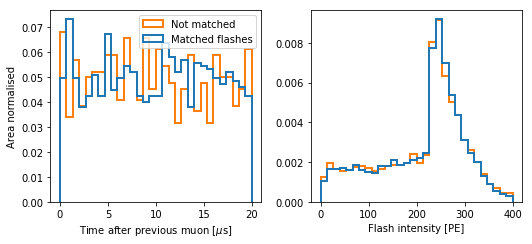

In [57]:
df_easy_muons = df_mc_muon_cross.query(query_easy_muons)

# The flashes arer sorted using PE, so we need to recalculate the time diff.
df_muons_sorted = df_mc_muon_cross.sort_values(by=['event','run','subrun','mc_time'])
df_muons_sorted['mc_difftime'] = df_muons_sorted['mc_time']-np.roll(df_muons_sorted['mc_time'],1) 
df_easy_muons_sorted = df_muons_sorted.query(query_easy_muons)

fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
labs = ['Matched flashes','Not matched']

data = [df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_good)]['mc_difftime']/1000,
        df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_bad)]['mc_difftime']/1000]
ax[0].hist(data, histtype='step', density=1,bins=30,range=(0,20),lw=2, label=labs)
data = [df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_good)]['mc_length_tpc'],
        df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_bad)]['mc_length_tpc']]
ax[1].hist(data, histtype='step', density=1,bins=30,range=(0,400),lw=2)
ax[0].legend()
ax[0].set_xlabel("Time after previous muon [$\mu$s]")
ax[1].set_xlabel("Flash intensity [PE]")
ax[0].set_ylabel("Area normalised")

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/sequentialmuoncheck.pdf", bbox_inches="tight")
